<a href="https://colab.research.google.com/github/vivekellanti/VehicleIdentification/blob/main/VehicleIdentifieripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Apr  9 01:05:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
pip install ultralytics
from IPython import display
display.clear_output()

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.1.45 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2024-04-10 01:50:43--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 108.177.98.139, 108.177.98.113, 108.177.98.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download [following]
--2024-04-10 01:50:43--  https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35345757 (34M) [video/mp4]
Saving to: ‘vehicle-counting.mp4’

vehicle-counting.mp 100%[===================>]  33.71M   219

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [ ]:
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.19.0


Load pre-trained YOLO V8 Model

model.fuse()
-Fusing reduces computational overhead as it goes through the model and automatically combines layers such as batch and convolutions into a fused layer. This reduces the  # of operations required to process input through the network.

Simple terms: You combine the predictions of a bunch of separate classifiers into a single prediction. In theory, this is better than the predictions of its individual constituents.

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 282MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


Predict and annotate a single frame

In [ ]:
#dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names

#class_ids of interest - car,motorcycle, bus, and truck
selected_classes = [2,3,5,7]



In [ ]:
import supervision as sv
import numpy as np

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


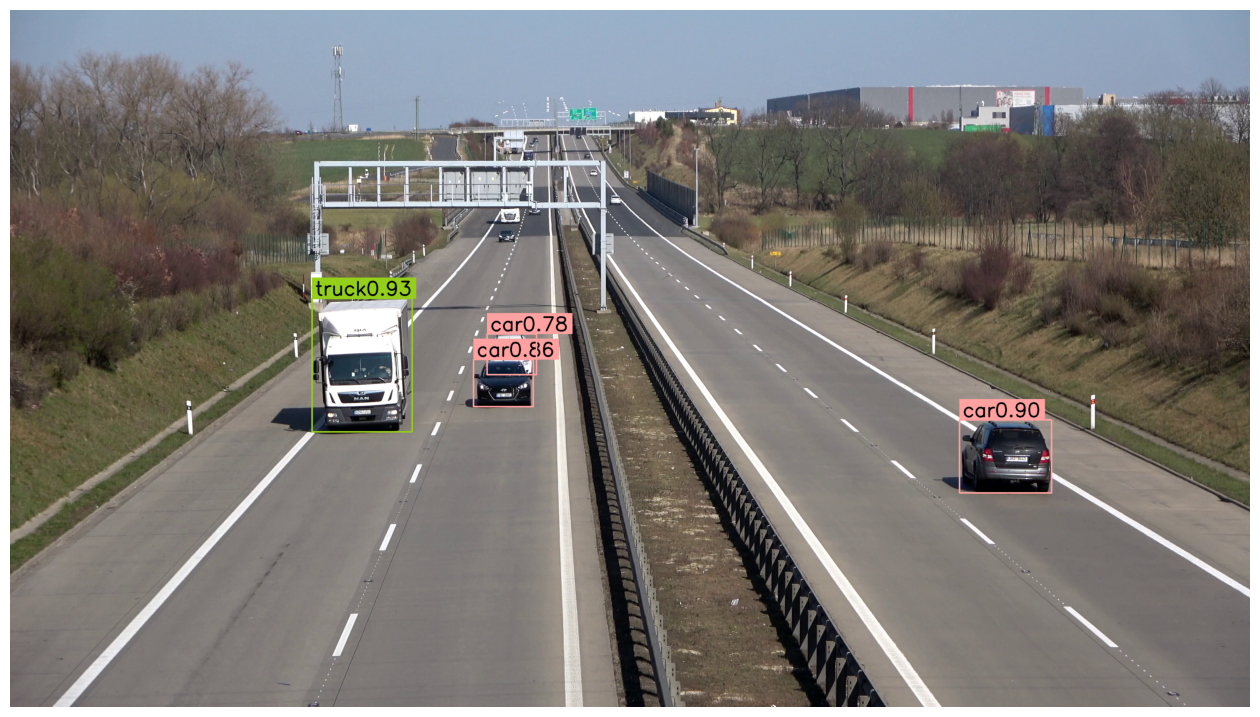

In [ ]:
#create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
#create instances of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
#acquire first video frame
iterator = iter(generator)
frame = next(iterator)
#model prediction on single frame and conversion to supervison detections
results = model(frame, verbose = False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)
#only consider class id from selected_classes defined above, np.isin is a numpy function that returns a boolean value after checking whether the first element is also in the second element. In this case we're checking to see if our detections are also in our selected classes
detections = detections[np.isin(detections.class_id, selected_classes)]

#format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]}{confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

#annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

Predict and annotate whole video

In [ ]:
#settings
LINE_START = sv.Point(50,1500)
LINE_END = sv.Point(3840-50,1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"


In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
# create ByteTracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

#create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

#create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

#create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start = LINE_START, end = LINE_END)

#create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

#create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

#create LineZoneAnnotator instance, previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

#define callback function to be used in video processing
def callback(frame:np.ndarray, index:int):
    #model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose = False)[0]
    detections = sv.Detections.from_ultralytics(results)

    #only consider class ID from selected classes above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    #tracking detections
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id}{model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene = frame.copy(),
        detections = detections
    )
    annotated_frame = box_annotator.annotate(
        scene = annotated_frame,
        detections = detections,
        labels = labels)
    #update line counter
    line_zone.trigger(detections)
    #return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame,line_counter=line_zone)

#process the whole video
sv.process_video(
    source_path= SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback

  )


SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
